### Objetivo

* El objetivo de la prueba es idear una solución para identificar transacciones que evidencian un 
comportamiento de Mala Práctica Transaccional, empleando un producto de datos. Adicional, 
describir la solución y detallar cómo incorporar el producto de datos en un marco operativo.

### Datos relevantes 

* Se entiende como una Mala Práctica Transaccional, un comportamiento donde se evidencia un 
uso de los canales mal intencionado; como Fraccionamiento transaccional.
* Fraccionamiento transaccional: esta es una mala práctica que consiste en fraccionar una transacción grande en varias pequeñas, estas transacciones se caracterizan por estar en una misma ventana de tiempo que suele ser 24 horas y tienen como origen o destino la misma cuenta o cliente. 


### EDA: 
*  Explorar los datos y realizar descriptivos de valor que permitan identificar los features e 
hipótesis bajo la cuales construirá el modelo analítico.

##########################################################################

* Intalacion de Bibliotecas
* Lectura de bibliotecas
* Descarga de datos y/o creacion de Pipeline
* Lectura de datos
* identificacion de usuarios que tienen mas de 2 transaciones en un solo dia
* Estadisticas descriptivas

### Diccionario

* _id: identificador único del registro 
* merchant_id: código único del comercio o aliado. 
* subsidiary: código único de la sede o sucursal. 
* transaction_date: fecha de transacción en el Core financiero. 
* account_number: número único de cuenta. 
* user_id: código único del usuario dueño de la cuenta desde donde se registran las transacciones. 
* transaction_amount: monto de la transacción (en moneda ficticia). 
* transaction_type: naturaleza de la transacción (crédito o débito). 

#### Supociciones iniciales 
* user_id: Suponemos que esta cuenta es la que recibe el dinero, porque de lo contrario no seria Mala practica transaccional si un user_id envia varias transferencias a distintos clientes en un lapso de 24h

### Intslacion librerias

In [73]:
import importlib
import subprocess
import sys

## Funcion para revisar si la libreria ya esta instalada, si no esta la instala.
def ensure_library_installed(library_name):
    try:
        # Intenta importar la librería
        importlib.import_module(library_name)
        print(f"La librería '{library_name}' ya está instalada.")
    except ImportError:
        print(f"La librería '{library_name}' no está instalada. Instalando ahora...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", library_name])
        print(f"Librería '{library_name}' instalada correctamente.")

# Ejemplo de uso
librerias =["gdown","matplotlib","pandas","pyspark","seaborn","scikit-learn","virtualenv"]
for i in librerias:
    ensure_library_installed(i)  

La librería 'gdown' ya está instalada.
La librería 'matplotlib' ya está instalada.
La librería 'pandas' ya está instalada.
La librería 'pyspark' ya está instalada.
La librería 'seaborn' ya está instalada.
La librería 'scikit-learn' no está instalada. Instalando ahora...
Librería 'scikit-learn' instalada correctamente.
La librería 'virtualenv' ya está instalada.


### Lectura de librerias

In [74]:
import pandas as pd
import os
import re
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from pyspark.sql.functions import to_timestamp, date_format
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, last, unix_timestamp, lag, to_date, round, sum as _sum
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import (
    StructType, StructField, StringType, TimestampType, DecimalType
)
import gc

#### Iniciar secion en spark y mejorar el rendimiento del cuaderno

In [75]:
# Initialize the SparkSession
spark = SparkSession.builder \
    .appName("Example App") \
    .getOrCreate()

# Set the configuration
spark.conf.set("spark.sql.repl.eagerEval.truncate", 0)  # Use 0 to disable truncation

In [76]:
# Iniciar sesión de Spark
spark = SparkSession.builder \
    .appName("Descargar y cargar archivo") \
    .getOrCreate()

In [77]:
spark = (
    SparkSession.builder
    .appName("Test")
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

### Pipelines de descarga y lectura

In [78]:
from pyspark.sql import SparkSession

# Iniciar sesión de Spark
spark = SparkSession.builder \
    .appName("Descargar y cargar archivo") \
    .getOrCreate()

# URL del archivo
url = "https://nequi-data.s3.us-east-1.amazonaws.com/sandbox_co/mscarmon/prueba_seleccion_ds/sample_data_0007_part_00.parquet"

# Ruta y nombre donde se guardará el archivo descargado
output_path = "C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0007_part_00.parquet"

# 1. Verificar si el archivo existe y eliminarlo si es necesario
if os.path.exists(output_path):
    os.remove(output_path)
    print(f"Archivo existente eliminado: {output_path}")

# 2. Descargar el archivo desde la URL
response = requests.get(url, stream=True)
if response.status_code == 200:  # porque si el codigo esta en estado 200 es porque el servidor respondio de manera exitosa
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Archivo descargado exitosamente como: {output_path}")

  # Leemos el archivo descargado
    df7 = spark.read.parquet(output_path)
    
    # Mostrar algunas filas como verificación
    df7.show(truncate=False)
else:
    print(f"Error al descargar el archivo: {response.status_code}")

print(df7.count())

Archivo existente eliminado: C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0007_part_00.parquet
Archivo descargado exitosamente como: C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0007_part_00.parquet
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+
|merchant_id                     |_id                             |subsidiary                      |transaction_date   |account_number                  |user_id                         |transaction_amount|transaction_type|
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+
|075d178871d8d48502bf1f54887e52fe|1cccf3eb51fe9ae64233cb4ffd2d0f8b|7428212cf0193f799447ec0dfe53e

In [79]:
from pyspark.sql import SparkSession

# Iniciar sesión de Spark
spark = SparkSession.builder \
    .appName("Descargar y cargar archivo") \
    .getOrCreate()

# URL del archivo
url = "https://nequi-data.s3.us-east-1.amazonaws.com/sandbox_co/mscarmon/prueba_seleccion_ds/sample_data_0006_part_00.parquet"

# Ruta y nombre donde se guardará el archivo descargado
output_path = "C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0006_part_00.parquet"

# 1. Verificar si el archivo existe y eliminarlo si es necesario
if os.path.exists(output_path):
    os.remove(output_path)
    print(f"Archivo existente eliminado: {output_path}")

# 2. Descargar el archivo desde la URL
response = requests.get(url, stream=True)
if response.status_code == 200:  # porque si el codigo esta en estado 200 es porque el servidor respondio de manera exitosa
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Archivo descargado exitosamente como: {output_path}")

  # Leemos el archivo descargado
    df6 = spark.read.parquet(output_path)
    
    # Mostrar algunas filas como verificación
    df6.show(truncate=False)
else:
    print(f"Error al descargar el archivo: {response.status_code}")

print(df6.count())

Archivo existente eliminado: C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0006_part_00.parquet
Archivo descargado exitosamente como: C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0006_part_00.parquet
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+
|merchant_id                     |_id                             |subsidiary                      |transaction_date   |account_number                  |user_id                         |transaction_amount|transaction_type|
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+
|075d178871d8d48502bf1f54887e52fe|aa8dacff663072244d0a8ab6bbe36b93|824b2af470cbe6a65b15650e03b74

In [80]:
# # Ruta y nombre donde se guardará el archivo descargado
# output_path = "C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0006_part_00.parquet"

# df6 = spark.read.parquet(output_path).sample(withReplacement=False, fraction=0.6, seed=42)
# # Ruta y nombre donde se guardará el archivo descargado
# # output_path = "C:/Users/jhonf/Descargas/Prueba_tecnica_Nequi/Data/sample_data_0007_part_00.parquet"
# df6.count()
# # df7 = spark.read.parquet(output_path)

In [81]:
## miramos con cuantos clientes únicos inicialmente estaríamos trabajando
df6.select("user_id").distinct().count()

1948844

In [82]:
# Función para corregir el nombre de la columna
def corregir_columna(columna):
    # Eliminar espacios al principio y al final
    columna = columna.strip()
    columna = columna.replace("%", "pct")
    columna = columna.replace(" ", "_").replace(".", "_")
    columna = columna.replace("'", "").replace('"', '')
    columna = columna.replace('//', '')
    columna = columna.replace("#", "")
    return columna

In [83]:
for columna in df6.columns:
    # Renombrar cada columna usando la función corregir_columna
    df6 = df6.withColumnRenamed(columna, corregir_columna(columna))
    # df7 = df7.withColumnRenamed(columna, corregir_columna(columna))

### Inicio de Analisis de la informacion

In [84]:
# print(df7.dtypes)
print(df6.dtypes)

[('merchant_id', 'string'), ('_id', 'string'), ('subsidiary', 'string'), ('transaction_date', 'timestamp'), ('account_number', 'string'), ('user_id', 'string'), ('transaction_amount', 'decimal(24,8)'), ('transaction_type', 'string')]


In [85]:
df6= df6.orderBy("transaction_date")
# df7= df7.orderBy("transaction_date")

In [86]:
# Seleccionar solo la columna user_id transaction_date en ambos DataFrames
df6_users = df6.select("user_id","transaction_date")
# df7_users = df7.select("user_id","transaction_date")

# Encontrar los valores comunes con intersect
# common_users = df6_users.intersect(df7_users)

# # Mostrar los resultados
# common_users.show(truncate=False)

In [87]:
print(df6.groupBy("transaction_type").count().show())
# print(df7.groupBy("transaction_type").count().show())

+----------------+-------+
|transaction_type|  count|
+----------------+-------+
|          DEBITO|8591289|
|         CREDITO|2167129|
+----------------+-------+

None


In [88]:

# print(df7.filter(df7["user_id"] == "7fda354dbc3e684bf414d3ab27208d79").show(truncate=False))

In [89]:
print(df6.count())

10758418


In [90]:
# Agrupar por las columnas relevantes y contar ocurrencias
duplicates = df6.groupBy("user_id", "transaction_date") \
    .count() \
    .filter("count > 1")

In [91]:
duplicates.show(truncate=False)  # posibles casos de duplicidad en la transaccion
# esto porque a la misma hora y fecha se realizo mas de una transaccion por el mismo valor pero con alguna 
# pequeña diferencia en el transaction_type

+--------------------------------+-------------------+-----+
|user_id                         |transaction_date   |count|
+--------------------------------+-------------------+-----+
|efaefdc05c78f8c4f1a852abd45ea9ce|2021-09-20 07:45:08|2    |
|ed240a7450d7c62fa39db8da3b85b3ac|2021-05-06 10:06:20|2    |
|4db601b869e6337011f6856269fa42d8|2021-04-21 14:16:58|2    |
|9bdd0bb257559c5b09f427903a0b4036|2021-01-12 02:35:21|2    |
|9da6cce8c8817d0b6947c5f1d0c3a232|2021-03-04 04:25:19|2    |
|10d4ea426c60b47a9b7437ec725475b5|2021-05-31 12:16:25|2    |
|58e86db19503ba2e4aee16d57f47686d|2021-10-13 11:01:19|2    |
|825f19d1c7904b7458d9ab6616598127|2021-06-21 07:25:06|2    |
|bd251f246fa1be448d6269d0ce86b646|2021-11-21 11:14:49|2    |
|85352b83bf8919cba4da71f68a4954c0|2021-11-27 11:23:54|2    |
|c1baa527eeab0d12454d2c335b93598a|2021-11-02 05:35:56|2    |
|aca7bc1d4f5cb160136aa768cf8fa2e5|2021-11-30 08:44:08|2    |
|955f1a9c66b3184ff37ddd7f100c908f|2021-01-15 09:45:10|2    |
|19c0a6abb4bf164f5fc3a16

In [92]:
# Eliminar duplicados basándose en la columna "_id"
dfu = df6.dropDuplicates(["_id"]) # Se deben quitar para ver cuantas transaciones eran iguales y encontrar posibles fraudes
dfu = dfu.dropDuplicates(["user_id", "transaction_date"])
print(dfu.count())

10758204


In [93]:
## Liberar espacio en memoria
del df6
del duplicates
del df6_users
gc.collect()

3451

In [94]:
# Asegúrate de que la columna transaction_date esté en formato timestamp
dfu = dfu.withColumn("transaction_time", to_timestamp(col("transaction_date"), "yyyy-MM-dd HH:mm:ss"))
dfu = dfu.orderBy("user_id", "transaction_time")

In [95]:
dfu.dtypes

[('merchant_id', 'string'),
 ('_id', 'string'),
 ('subsidiary', 'string'),
 ('transaction_date', 'timestamp'),
 ('account_number', 'string'),
 ('user_id', 'string'),
 ('transaction_amount', 'decimal(24,8)'),
 ('transaction_type', 'string'),
 ('transaction_time', 'timestamp')]

#### Calculo de las ventanas de tiempo y diferencia en horas entre transaciones

In [96]:
# === 1) Definir la columna 'day' ===
dfu = dfu.withColumn("day", to_date(col("transaction_time")))

# === 2) Detectar cambio de día con lag(day) ===
# Ventana principal: particionamos por user_id y ordenamos por transaction_time
w_user_order = Window.partitionBy("user_id").orderBy("transaction_time")

dfu = dfu.withColumn(
    "prev_day",
    lag("day").over(w_user_order)
)

# Creamos una bandera day_change que es 1 cuando cambia el día, 0 si es el mismo día
dfu = dfu.withColumn(
    "day_change_flag",
    when(col("prev_day").isNull(), 0)  # primera transacción => no cambia día
    .when(col("day") != col("prev_day"), 1)
    .otherwise(0)
)

# === 3) day_group: identificador acumulado de cada día, por usuario ===
# Sumar en forma acumulada la bandera day_change_flag
dfu = dfu.withColumn(
    "day_group",
    _sum("day_change_flag").over(w_user_order)
)
# Así, cada vez que day_change_flag = 1, se incrementa day_group en 1

# --- Limpieza opcional ---
dfu = dfu.drop("prev_day", "day_change_flag")

# === 4) Calcular diff_hours dentro de cada día_group ===
#  (1) Definir ventana que particiona por user_id y day_group, ordena por fecha/hora
w_user_day = Window.partitionBy("user_id", "day_group").orderBy("transaction_time")

# (2) Calcular la transacción anterior dentro del mismo day_group
dfu = dfu.withColumn(
    "prev_tr_time_tmp",
    lag("transaction_time").over(w_user_day)
)

# (3) Si es la primera transacción del day_group, prev_tr_time_tmp estará en null
#     Asignamos la transaction_time actual para que diff_hours = 0 en esa fila
dfu = dfu.withColumn(
    "prev_tr_time",
    when(col("prev_tr_time_tmp").isNull(), col("transaction_time"))
    .otherwise(col("prev_tr_time_tmp"))
)
dfu = dfu.drop("prev_tr_time_tmp")

# (4) Calcular diff_hours
dfu = dfu.withColumn(
    "diff_hours",
    (unix_timestamp("transaction_time") - unix_timestamp("prev_tr_time")) / 3600
)

dfu = dfu.withColumn(
    "diff_minutes",
    (unix_timestamp("transaction_time") - unix_timestamp("prev_tr_time")) / 60
)

# === 5) new_window_flag: si diff_hours > 24, se abre una nueva ventana ===
dfu = dfu.withColumn(
    "new_window_flag",
    when(col("diff_hours") > 24, 1).otherwise(0)
)

# === 6) Calcular windows_time dentro de cada day_group ===
#     - sumamos en forma acumulada new_window_flag y le sumamos 1 para iniciar en 1
dfu = dfu.withColumn(
    "windows_time",
    _sum("new_window_flag").over(w_user_day) + 1
)

# (Opcional) limpiar columnas
dfu = dfu.drop("new_window_flag","windows_time")
dfu = dfu.withColumnRenamed("day_group", "windows_time")
# Ajustar la columna "day_group" para que inicie en 1
dfu = dfu.withColumn("windows_time", col("windows_time") + 1)
# dfu.show(truncate=False)
## redondeamos a 2 decimales
dfu = dfu.withColumn("diff_hours", round(col("diff_hours"), 2))
dfu = dfu.withColumn("diff_minutes", round(col("diff_minutes"), 2))

In [97]:
print(dfu.dtypes)

[('merchant_id', 'string'), ('_id', 'string'), ('subsidiary', 'string'), ('transaction_date', 'timestamp'), ('account_number', 'string'), ('user_id', 'string'), ('transaction_amount', 'decimal(24,8)'), ('transaction_type', 'string'), ('transaction_time', 'timestamp'), ('day', 'date'), ('windows_time', 'bigint'), ('prev_tr_time', 'timestamp'), ('diff_hours', 'double'), ('diff_minutes', 'double')]


### Ejemplos de confirmacion de que la estructura esta correcta.

In [98]:
print(dfu.filter(dfu["user_id"] == "c5577151d00040760bf065136fabd47b").show(truncate=False))

+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+-------------------+----------+------------+-------------------+----------+------------+
|merchant_id                     |_id                             |subsidiary                      |transaction_date   |account_number                  |user_id                         |transaction_amount|transaction_type|transaction_time   |day       |windows_time|prev_tr_time       |diff_hours|diff_minutes|
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+-------------------+----------+------------+-------------------+----------+------------+
|817d18cd3c31e40e9bff0566baae7758|c1e67f9632bcf995b75d375cdc9a1d99|

In [99]:
print(dfu.filter(dfu["user_id"] == "cfa366b65fa843bf78ca52f9524e1244").show(truncate=False))

+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+-------------------+----------+------------+-------------------+----------+------------+
|merchant_id                     |_id                             |subsidiary                      |transaction_date   |account_number                  |user_id                         |transaction_amount|transaction_type|transaction_time   |day       |windows_time|prev_tr_time       |diff_hours|diff_minutes|
+--------------------------------+--------------------------------+--------------------------------+-------------------+--------------------------------+--------------------------------+------------------+----------------+-------------------+----------+------------+-------------------+----------+------------+
|838a8fa992a4aa2fb5a0cf8b15b63755|aa3a1d6327b6bb5b7600399806b0716e|

In [100]:
dfu = dfu.drop("prev_tr_time","day")

In [101]:
dfu.filter(dfu["diff_minutes"] != 0).describe().show(truncate=False)

+-------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+------------------+----------------+-----------------+------------------+------------------+
|summary|merchant_id                     |_id                             |subsidiary                      |account_number                  |user_id                         |transaction_amount|transaction_type|windows_time     |diff_hours        |diff_minutes      |
+-------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+------------------+----------------+-----------------+------------------+------------------+
|count  |1544301                         |1544301                         |1544301                         |1544301                         |1544301                         |1544301           |154430

### Identificacion de usuarios que tienen  mas de dos transaciones en un solo dia

In [30]:
# Agrupar por 'user_id' y 'windows_time', contar los 'windows_time' y sumar 'transaction_amount'
df_count = dfu.groupBy("user_id", "windows_time") \
    .agg(
        F.count("windows_time").alias("windows_time_count"),
        F.sum("transaction_amount").alias("total_transaction_amount"),
        F.avg("diff_hours").alias("avg_diff_hours"),  # Promedio de diff_hours
        F.avg("diff_minutes").alias("avg_diff_minutes")  # Promedio de diff_minutes
    )
# Filtrar aquellos 'user_id' donde el conteo de 'windows_time' sea mayor a 2
df_filtered = df_count.filter(F.col("windows_time_count") > 2)
# Ordenar por total_transaction_amount de mayor a menor
df_filtered = df_filtered.orderBy(F.col("total_transaction_amount").desc())
# Mostrar el resultado
print('# Usuarios unicos que estan haciendo Fraccionamiento transaccional',df_filtered.select("user_id").distinct().count())
df_filtered.show(truncate=False)

# Usuarios unicos que estan haciendo Fraccionamiento transaccional 43571
+--------------------------------+------------+------------------+------------------------+--------------------+------------------+
|user_id                         |windows_time|windows_time_count|total_transaction_amount|avg_diff_hours      |avg_diff_minutes  |
+--------------------------------+------------+------------------+------------------------+--------------------+------------------+
|7cac676a8d21f4fb7a66d4966dd3a12c|5           |18                |10628.69031758          |0.12722222222222224 |7.593333333333332 |
|0290610111640c1d5b863240bb81d3b4|24          |4                 |10105.57352101          |0.09                |5.46              |
|c053e50fbd1c87d3f6ebfcc6a1ad1ee3|1           |3                 |9630.01712001           |0.01                |0.6333333333333333|
|0bc8aec7fa627188bcd48c2ba576cca5|1           |3                 |9630.01712001           |0.12333333333333334 |7.443333333333334 |
|84

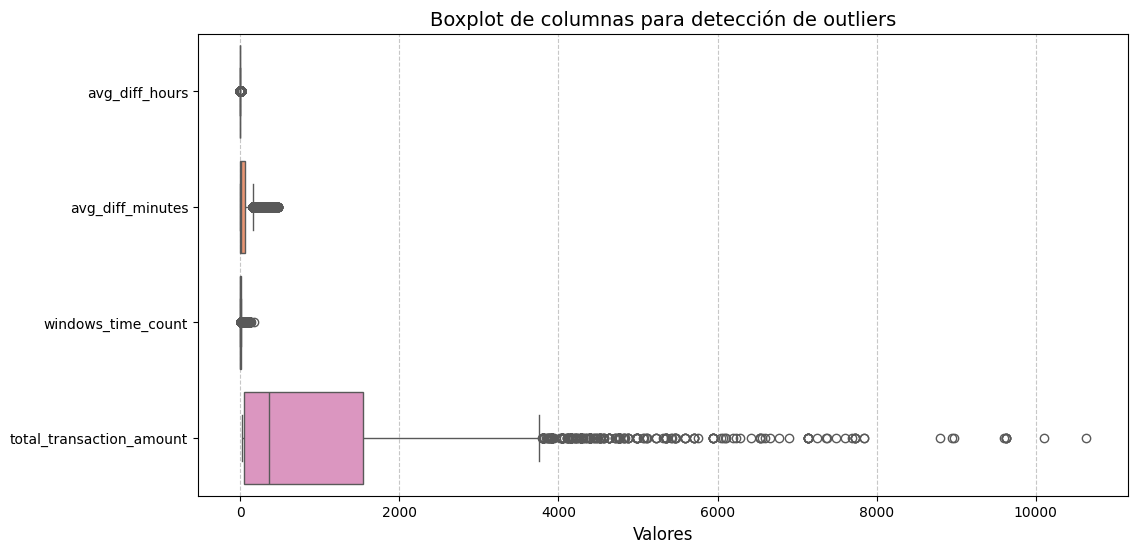

In [31]:
# Seleccionar las columnas relevantes y convertirlas a pandas
columns_to_plot = ['avg_diff_hours','avg_diff_minutes', 'windows_time_count', 'total_transaction_amount']
df_pandas = df_filtered.select(columns_to_plot).toPandas()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el boxplot para todas las columnas seleccionadas
sns.boxplot(data=df_pandas, orient="h", palette="Set2")

# Personalización
plt.title('Boxplot de columnas para detección de outliers', fontsize=14)
plt.xlabel('Valores', fontsize=12)
plt.yticks(range(len(columns_to_plot)), columns_to_plot, fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

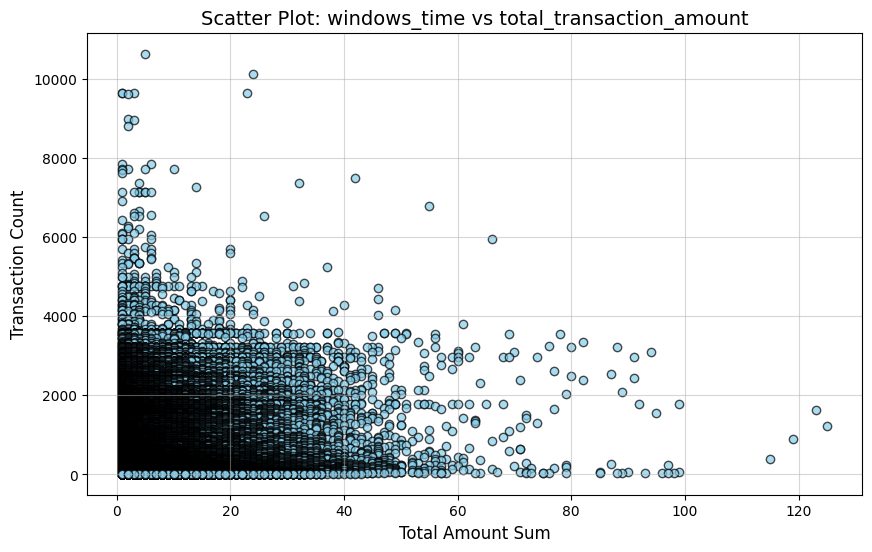

In [32]:
# Seleccionar solo las columnas necesarias y convertirlas a pandas
df_pandas2 = df_filtered.select('windows_time', 'total_transaction_amount').toPandas()

# Crear el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas2['windows_time'], df_pandas2['total_transaction_amount'], alpha=0.7, color='skyblue', edgecolor='black')

# Personalización de la gráfica
plt.title('Scatter Plot: windows_time vs total_transaction_amount', fontsize=14)
plt.xlabel('Total Amount Sum', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.grid(alpha=0.5)

# Mostrar la gráfica
plt.show()

In [33]:
df_filtered.describe().show()

+-------+--------------------+-----------------+------------------+------------------------+------------------+--------------------+
|summary|             user_id|     windows_time|windows_time_count|total_transaction_amount|    avg_diff_hours|    avg_diff_minutes|
+-------+--------------------+-----------------+------------------+------------------------+------------------+--------------------+
|  count|               72029|            72029|             72029|                   72029|             72029|               72029|
|   mean|                NULL|7.632286995515695| 5.765913729192409|        830.096916166499|0.7276020182202634|   43.64824167995813|
| stddev|                NULL|7.998216426452618| 9.626653712523245|       955.9422806771545| 1.149973938007864|   68.99955201062245|
|    min|0002ad97e3f83b08a...|                1|                 3|             17.83336503|               0.0|0.013333333333333334|
|    max|fffa2a7ba58554e78...|              125|               172|  

In [34]:
stats = df_pandas[df_pandas['total_transaction_amount']<3000].describe()

# Extraer estadísticas relevantes
mean_diff_minutes = stats.loc['mean', 'avg_diff_minutes']
median_diff_minutes = stats.loc['50%', 'avg_diff_minutes']

# Generar el texto interpretativo
analysis = (f"De los anteriores datos podemos ver que para las transacciones totales menores a 3000 dólares, "
            f"el tiempo promedio entre transacciones es de {mean_diff_minutes:.2f} minutos. "
            f"y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a "
            f"{median_diff_minutes:.2f} minutos.")

# Mostrar el análisis
print(analysis)

De los anteriores datos podemos ver que para las transacciones totales menores a 3000 dólares, el tiempo promedio entre transacciones es de 44.32 minutos. y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a 5.79 minutos.


In [35]:
stats = df_pandas[df_pandas['total_transaction_amount']>=3000].describe()

# Extraer estadísticas relevantes
mean_diff_minutes = stats.loc['mean', 'avg_diff_minutes']
median_diff_minutes = stats.loc['50%', 'avg_diff_minutes']

# Generar el texto interpretativo
analysis = (f"De los anteriores datos podemos ver que para las transacciones totales mayores e iguales a 3000 dólares, "
            f"el tiempo promedio entre transacciones es de {mean_diff_minutes:.2f} minutos. "
            f"y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a "
            f"{median_diff_minutes:.2f} minutos.")

# Mostrar el análisis
print(analysis)

De los anteriores datos podemos ver que para las transacciones totales mayores e iguales a 3000 dólares, el tiempo promedio entre transacciones es de 13.67 minutos. y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a 1.47 minutos.


### Estadisticas descriptivas


#### Esto nos muestra que la principal merchant_id, donde la merchant_id '817d18cd3c31e40e9bff0566baae7758' tiene más de 4360340 transacciones, de comercios aliados. siendo esta la principal



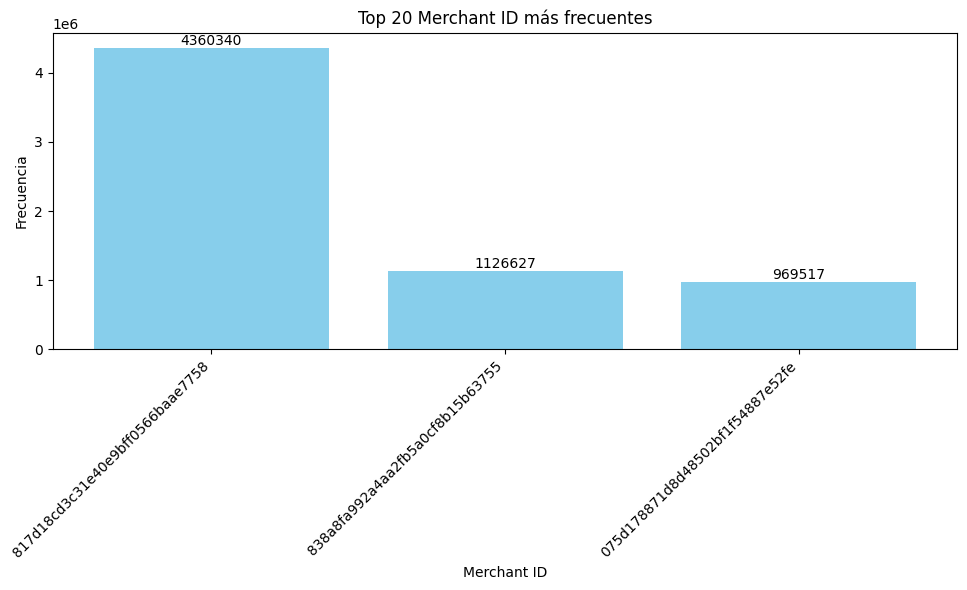

In [36]:
# Obtener los 20 merchant_id más frecuentes
top_20_pandas = dfu.groupBy("merchant_id").agg(count("*").alias("frecuencia")).orderBy(col("frecuencia").desc()).limit(20).toPandas()
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_pandas["merchant_id"], top_20_pandas["frecuencia"], color="skyblue")
# Añadir etiquetas con el conteo encima de las barras
for bar, frecuencia in zip(bars, top_20_pandas["frecuencia"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(frecuencia), 
             ha="center", va="bottom", fontsize=10)
# Personalizar el gráfico
plt.xticks(rotation=45, ha="right")
plt.xlabel("Merchant ID")
plt.ylabel("Frecuencia")
plt.title("Top 20 Merchant ID más frecuentes")
plt.tight_layout()

# Generar resumen automático
merchant_id_top = top_20_pandas.iloc[0]  # Subsidiary con más transacciones
merchant_id_name = merchant_id_top["merchant_id"]
max_transactions = merchant_id_top["frecuencia"]

resumen = f"""
#### Esto nos muestra que la principal merchant_id, donde la merchant_id '{merchant_id_name}' tiene más de {max_transactions} transacciones, de comercios aliados. siendo esta la principal
"""
print(resumen)


#### Esto nos muestra las 20 principales subsidiary, donde la subsidiary 'f54e0b6b32831a6307361ed959903e76' tiene más de 214298 transacciones sindo la principal subsidiary.



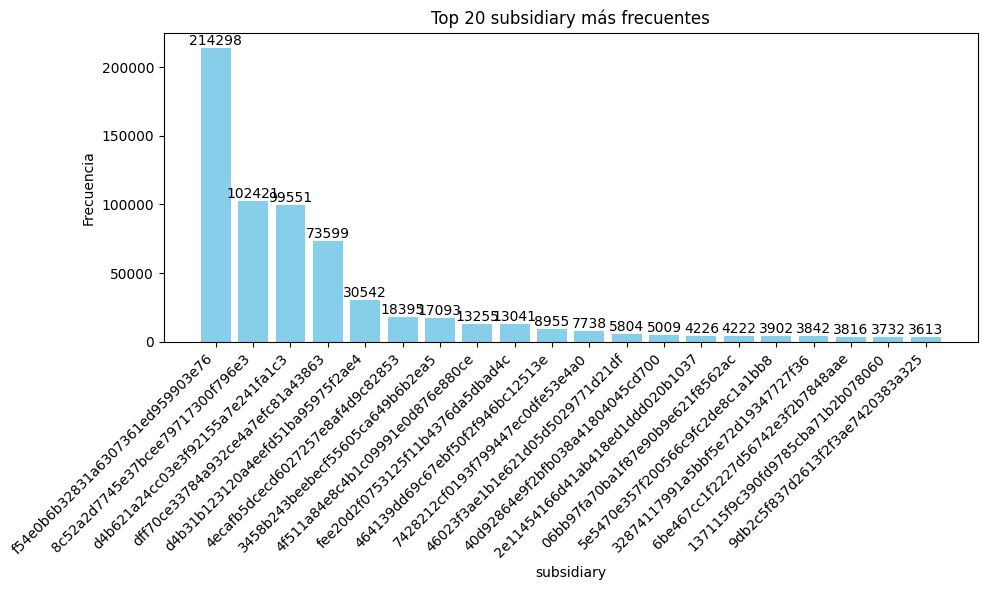

In [37]:
# Obtener los 20 subsidiary más frecuentes
top_20_pandas = dfu.groupBy("subsidiary").agg(count("*").alias("frecuencia")).orderBy(col("frecuencia").desc()).limit(20).toPandas()
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_pandas["subsidiary"], top_20_pandas["frecuencia"], color="skyblue")
# Añadir etiquetas con el conteo encima de las barras
for bar, frecuencia in zip(bars, top_20_pandas["frecuencia"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(frecuencia), 
             ha="center", va="bottom", fontsize=10)
# Personalizar el gráfico
plt.xticks(rotation=45, ha="right")
plt.xlabel("subsidiary")
plt.ylabel("Frecuencia")
plt.title("Top 20 subsidiary más frecuentes")
plt.tight_layout()

# Generar resumen automático para Subsidiary
subsidiary_top = top_20_pandas.iloc[0]  # Subsidiary con más transacciones
subsidiary_name = subsidiary_top["subsidiary"]
max_transactions = subsidiary_top["frecuencia"]

resumen = f"""
#### Esto nos muestra las 20 principales subsidiary, donde la subsidiary '{subsidiary_name}' tiene más de {max_transactions} transacciones siendo la principal subsidiary.
"""
print(resumen)

In [38]:
summary = dfu.select("transaction_amount").summary().filter(col("summary").isin("max", "min", "mean","stddev"))
summary_pandas = summary.toPandas()

# Extraer valores
max_value = float(summary_pandas.loc[summary_pandas["summary"] == "max", "transaction_amount"].iloc[0])
min_value = float(summary_pandas.loc[summary_pandas["summary"] == "min", "transaction_amount"].iloc[0])
mean_value = float(summary_pandas.loc[summary_pandas["summary"] == "mean", "transaction_amount"].iloc[0])
std_value = float(summary_pandas.loc[summary_pandas["summary"] == "stddev", "transaction_amount"].iloc[0])
texto = f"""
Aquí vemos que el monto máximo de la transacción es de {max_value:.2f} dólares, 
el mínimo es de {min_value:.2f} dólares y la media es de {mean_value:.2f} dólares, y su desviacion general puede llegar a ser de {std_value:.2f}.
"""
print(texto)


Aquí vemos que el monto máximo de la transacción es de 4624.79 dólares, 
el mínimo es de 5.94 dólares y la media es de 191.39 dólares, y su desviacion general puede llegar a ser de 240.90.




#### Esto nos muestra que la principal transaction_type, donde la transaction_type 'DEBITO' tiene más de 5155223 transacciones, siendo esta la principal



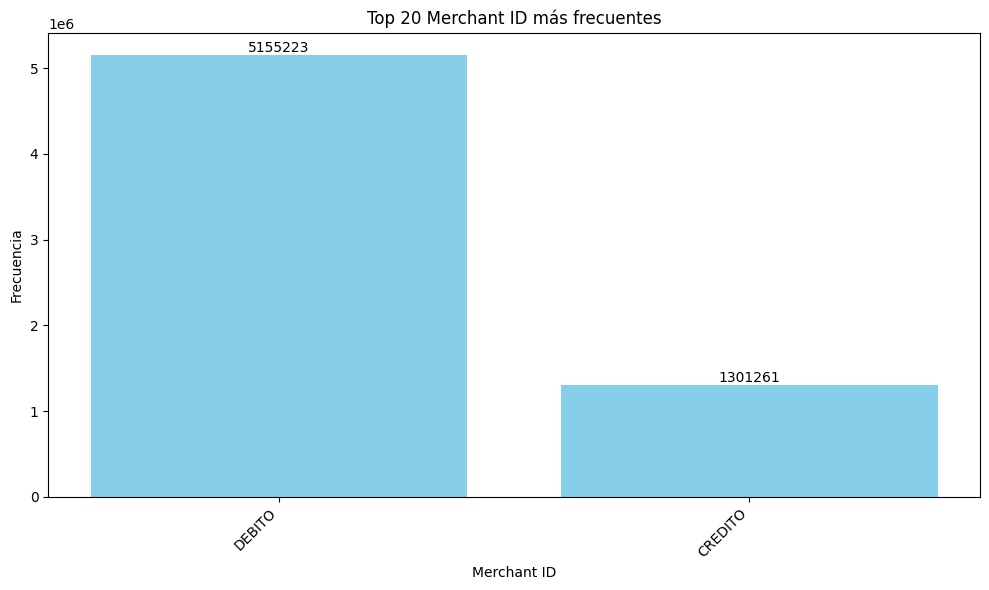

In [39]:
# Obtener los 20 transaction_type más frecuentes
top_20_pandas = dfu.groupBy("transaction_type").agg(count("*").alias("frecuencia")).orderBy(col("frecuencia").desc()).limit(20).toPandas()
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_pandas["transaction_type"], top_20_pandas["frecuencia"], color="skyblue")
# Añadir etiquetas con el conteo encima de las barras
for bar, frecuencia in zip(bars, top_20_pandas["frecuencia"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(frecuencia), 
             ha="center", va="bottom", fontsize=10)
# Personalizar el gráfico
plt.xticks(rotation=45, ha="right")
plt.xlabel("Merchant ID")
plt.ylabel("Frecuencia")
plt.title("Top 20 Merchant ID más frecuentes")
plt.tight_layout()

# Generar resumen automático para las Merchant ID
transaction_type_top = top_20_pandas.iloc[0]  # Merchant ID con más transacciones
transaction_type_name = transaction_type_top["transaction_type"]
max_transactions = transaction_type_top["frecuencia"]

resumen = f"""
#### Esto nos muestra que la principal transaction_type, donde la transaction_type '{transaction_type_name}' tiene más de {max_transactions} transacciones, siendo esta la principal
"""
print(resumen)

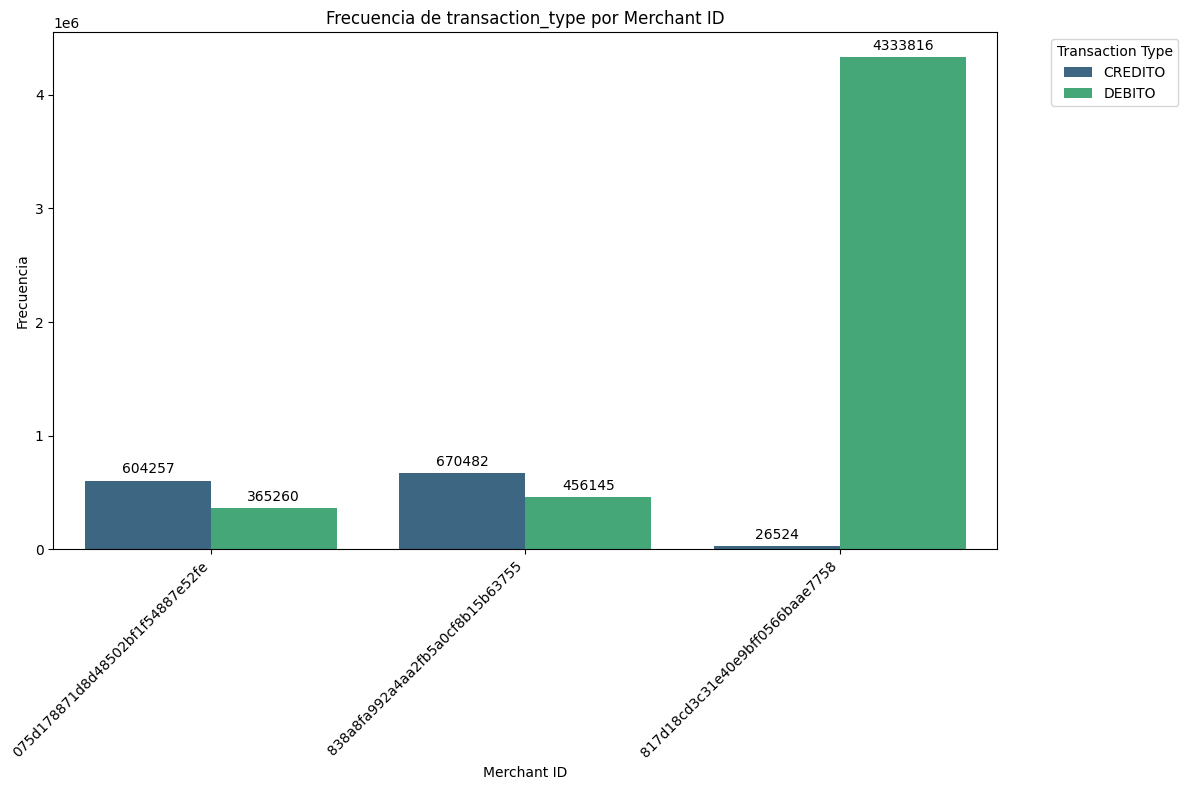

In [40]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por merchant_id y transaction_type, contar ocurrencias
grouped_data = dfu.groupBy("merchant_id", "transaction_type").agg(count("*").alias("frecuencia"))

# Convertir a Pandas para graficar
grouped_data_pandas = grouped_data.toPandas()

# Crear una gráfica de barras con Seaborn
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(
    data=grouped_data_pandas,
    x="merchant_id",
    y="frecuencia",
    hue="transaction_type",
    palette="viridis"
)

# Agregar conteo encima de cada barra
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt="%.0f", label_type="edge", padding=3)

# Personalizar la gráfica
plt.xticks(rotation=45, ha="right")
plt.xlabel("Merchant ID")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de transaction_type por Merchant ID")
plt.legend(title="Transaction Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Mostrar la gráfica
plt.show()

#### Esta grafica es interesante dado que me indica que el mayor comercio aliada genera en su mayoria transaciones debito.

In [41]:
# dfu = dfu.withColumn("Fecha_dia", to_timestamp(col("transaction_date"), "yyyy-MM-dd HH:mm:ss"))
from pyspark.sql.functions import to_date
dfu = dfu.withColumn("Fecha_dia", to_date(col("transaction_date"), "yyyy-MM-dd"))

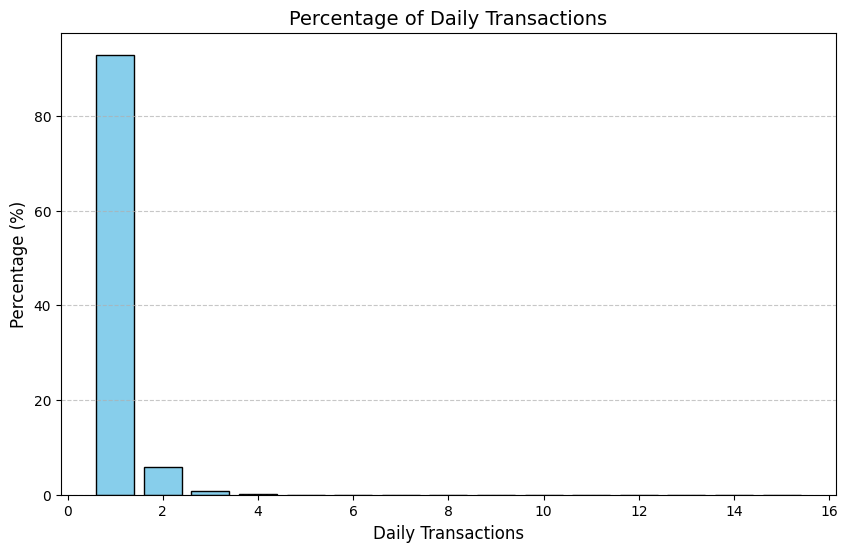

In [42]:
df_f=dfu.groupBy('user_id','Fecha_dia').agg(F.count("*").alias("daily_transactions"))
# Calcular el total de frecuencias para convertir a porcentajes
total_frequency = df_f.count()

# Calcular la frecuencia y añadir columna de porcentaje
df_value_counts = df_f.groupBy("daily_transactions") \
    .agg(F.count("*").alias("frequency")) \
    .withColumn("percentage", (F.col("frequency") / total_frequency) * 100) \
    .orderBy("daily_transactions")

# Convertir a Pandas y tomar los primeros 15 datos
df_pandas = df_value_counts.toPandas().head(15)

# Graficar en porcentaje
plt.figure(figsize=(10, 6))
plt.bar(df_pandas["daily_transactions"], df_pandas["percentage"], color='skyblue', edgecolor='black')
plt.xlabel("Daily Transactions", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Percentage of Daily Transactions", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [50]:
import builtins
prob = builtins.round(row["percentage"], 2)
cum_prob = builtins.round(row["cumulative_percentage"], 2)

import builtins  # Importa la versión nativa de round

# Convertir a Pandas si es necesario
if not isinstance(df_pandas, pd.DataFrame):
    df_pandas = df_pandas.toPandas()

# Asegurar que las columnas son del tipo correcto
df_pandas["percentage"] = df_pandas["percentage"].astype(float)
df_pandas["cumulative_percentage"] = df_pandas["cumulative_percentage"].astype(float)

# Generar el texto de las probabilidades
output = []
for idx, row in df_pandas.iterrows():
    daily = row["daily_transactions"]
    prob = builtins.round(row["percentage"], 2)  # Usar round de Python
    cum_prob = builtins.round(row["cumulative_percentage"], 2)  # Usar round de Python

    if daily == 1:
        output.append(f"Dado que una persona utiliza Nequi y tiene transacciones en Nequi, la probabilidad de que el número de transacciones sea 1 es de {prob}%.")
    else:
        output.append(f"La probabilidad de que sus transacciones sean {daily} transacciones es del {prob}%.")

    if cum_prob >= 98.75:  # Parar cuando se alcanza el 98.75%
        output.append(f"La probabilidad de que reciba una o dos transacciones en un día es del {cum_prob}%.")
        break

# Calcular la probabilidad de 3 o más transacciones
prob_mayor_igual_3 = builtins.round(100 - cum_prob, 2)
output.append(f"La probabilidad de que el número de transacciones sea mayor o igual a 3 es del {prob_mayor_igual_3}%.")

# Mostrar el texto generado
for line in output:
    print(line)

Dado que una persona utiliza Nequi y tiene transacciones en Nequi, la probabilidad de que el número de transacciones sea 1 es de 92.91%.
La probabilidad de que sus transacciones sean 2.0 transacciones es del 5.84%.
La probabilidad de que reciba una o dos transacciones en un día es del 98.75%.
La probabilidad de que el número de transacciones sea mayor o igual a 3 es del 1.25%.


In [52]:
# Calcular el número promedio de transacciones
total_transactions = (df_pandas["daily_transactions"] * df_pandas["frequency"]).sum()
total_frequency = df_pandas["frequency"].sum()
average_transactions = total_transactions / total_frequency

print(f"El número promedio de transacciones en un día es: {average_transactions:.2f}")

El número promedio de transacciones en un día es: 1.09


In [53]:
# 1. Definir una ventana particionada por user_id y ordenada por transaction_time
window_spec = Window.partitionBy("user_id").orderBy("transaction_time")

# 2. Calcular la transacción anterior (lag)
dfu = dfu.withColumn(
    "prev_time",
    F.lag("transaction_time").over(window_spec)
)

# 3. llenar los nulos de la columna prev_time
# window_spec = Window.partitionBy("user_id").orderBy(col("transaction_time").desc())
# Usar forward fill en el orden inverso (simula bfill)
dfu = dfu.withColumn(
    "prev_time",
    last("prev_time", ignorenulls=True).over(window_spec)
)
dfu = dfu.withColumn(
    "prev_time",
    when(col("prev_time").isNull(), col("transaction_time")).otherwise(col("prev_time"))
)
# Restaurar el orden original si es necesario
dfu = dfu.orderBy("user_id", "transaction_time")

# dfu.show()

In [54]:
# 3. Calcular diferencia en segundos entre la transacción actual y la anterior
dfu = dfu.withColumn(
    "diff_seconds",
    F.unix_timestamp("transaction_time") - F.unix_timestamp("prev_time")
)

# Calcular diferencia en dias
dfu = dfu.withColumn(
    "diff_days",
    (F.unix_timestamp("transaction_time") - F.unix_timestamp("prev_time")) / (60 * 60 * 24)
)
# dfu.show()

In [55]:
dfd = dfu.select('user_id','diff_days','transaction_amount','Fecha_dia').filter(F.col("diff_days") != 0)

Área bajo la curva (AUC): 0.7581314514476972. Nos indica que hay una probabilidad de 0.7581314514476972 de que una persona haga una tranasacion en aproximadamente 40 dias o antes


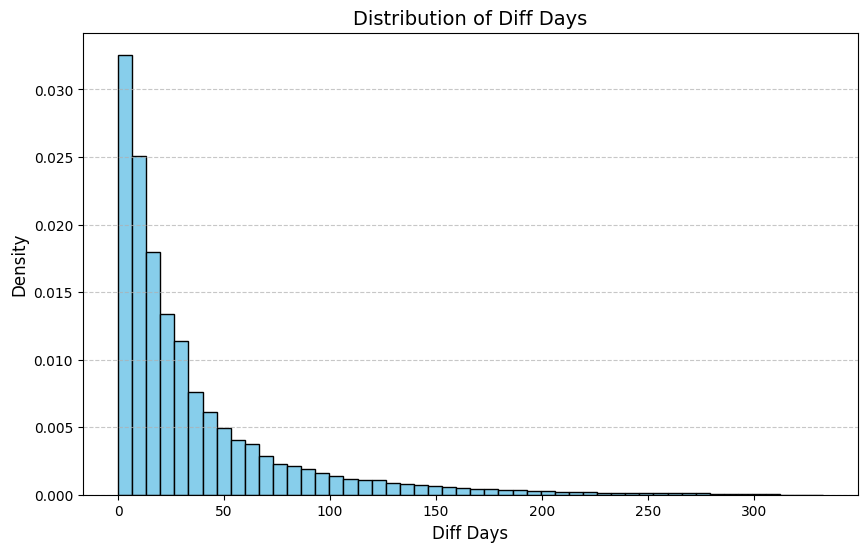

In [56]:
# Graficar la distribución de diff_days
import numpy as np
import matplotlib.pyplot as plt

# Calcular la frecuencia de los valores de diff_days
df_diff_days_count = dfd.groupBy("diff_days").count().orderBy("diff_days")

# Convertir a Pandas
df_pandas = df_diff_days_count.toPandas()

# Graficar la distribución de diff_days
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_pandas["diff_days"], bins=50, density=True, color='skyblue', edgecolor='black')
plt.xlabel("Diff Days", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Diff Days", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Calcular el área bajo la curva (AUC)
bin_width = bins[1] - bins[0]  # Ancho de cada barra
area = np.sum(n[0:7] * bin_width)  # Sumar la densidad multiplicada por el ancho de la barra

print(f"Área bajo la curva (AUC): {area}.", f"Nos indica que hay una probabilidad de {area} de que una persona haga una tranasacion en aproximadamente 40 dias o antes")

plt.show()

In [57]:
del dfd
del grouped_data_pandas
del grouped_data
del summary_pandas
gc.collect()

138

In [58]:
dfu.limit(3).show()

+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+----------------+-------------------+------------+----------+------------+----------+-------------------+------------+-----------------+
|         merchant_id|                 _id|          subsidiary|   transaction_date|      account_number|             user_id|transaction_amount|transaction_type|   transaction_time|windows_time|diff_hours|diff_minutes| Fecha_dia|          prev_time|diff_seconds|        diff_days|
+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+----------------+-------------------+------------+----------+------------+----------+-------------------+------------+-----------------+
|838a8fa992a4aa2fb...|ecba8ff3dc6593175...|1c9c7c96fcd19d206...|2021-01-26 13:29:08|3fadf4b282c09463f...|000002373d5835d0e...|       29.72227506|         

In [59]:
# df_grouped =dfu.select('user_id','Fecha_dia','transaction_amount').toPandas()

In [60]:
# df_grouped = (
#     dfu.groupby(['user_id', 'Fecha_dia'])
#       .agg(
#           total_amount_sum=('transaction_amount', 'sum'),  # Suma de total_mount
#           transaction_count=('Fecha_dia', 'count')  # Número de transacciones
#       )
#       .reset_index()
# )

# df_grouped

In [61]:
# Agrupar por user_id y Fecha_dia, y calcular la suma del monto total y el conteo de transacciones
df_grouped = dfu.groupBy("user_id", "Fecha_dia").agg(
    F.sum("transaction_amount").alias("total_amount_sum"),  # Suma del monto total
    F.count("Fecha_dia").alias("transaction_count")  # Número de transacciones
)

In [62]:
df_grouped.show()

+--------------------+----------+----------------+-----------------+
|             user_id| Fecha_dia|total_amount_sum|transaction_count|
+--------------------+----------+----------------+-----------------+
|001d61384f01c6384...|2021-11-06|    475.55640098|                2|
|00251b3c71a55cf55...|2021-08-31|     23.77782004|                1|
|0025785d6d20ef2d1...|2021-09-16|    261.55602054|                1|
|00337d11cda368921...|2021-05-15|    356.66730074|                1|
|0045b8b46376b446b...|2021-08-23|    237.77820049|                1|
|004b426102f0d2014...|2021-10-11|     35.66673007|                1|
|00536985acd7d5ff8...|2021-07-22|    178.33365037|                1|
|005baca47dad8c074...|2021-01-11|    321.00057065|                3|
|006b9d97da8af049c...|2021-10-31|     59.44455012|                1|
|0072dd22c6f29130b...|2021-03-16|     95.11128019|                1|
|00a4eb0d65b78a36b...|2021-09-17|     59.44455012|                1|
|00a652dc160c06031...|2021-01-22| 

In [63]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Agrupar por 'transaction_count' y contar las ocurrencias
df_counts = df_grouped.groupBy("transaction_count").agg(
    F.count("*").alias("frequency")
)

# Calcular el total de filas para normalizar
total_count = df_counts.agg(F.sum("frequency")).collect()[0][0]

# Normalizar la frecuencia
df_counts_normalized = df_counts.withColumn(
    "normalized_frequency", F.col("frequency") / total_count * 100
)

# Mostrar los primeros 20 registros
df_counts_normalized = df_counts_normalized.orderBy("transaction_count").limit(20)

# Convertir a Pandas para graficar
df_pandas = df_counts_normalized.toPandas()

# Mostrar el DataFrame
print(df_pandas)

    transaction_count  frequency  normalized_frequency
0                   1    5366267             92.910338
1                   2     337452              5.842568
2                   3      49664              0.859871
3                   4      11395              0.197290
4                   5       2550              0.044150
5                   6       1007              0.017435
6                   7        526              0.009107
7                   8        337              0.005835
8                   9        312              0.005402
9                  10        265              0.004588
10                 11        253              0.004380
11                 12        246              0.004259
12                 13        246              0.004259
13                 14        224              0.003878
14                 15        188              0.003255
15                 16        193              0.003342
16                 17        192              0.003324
17        

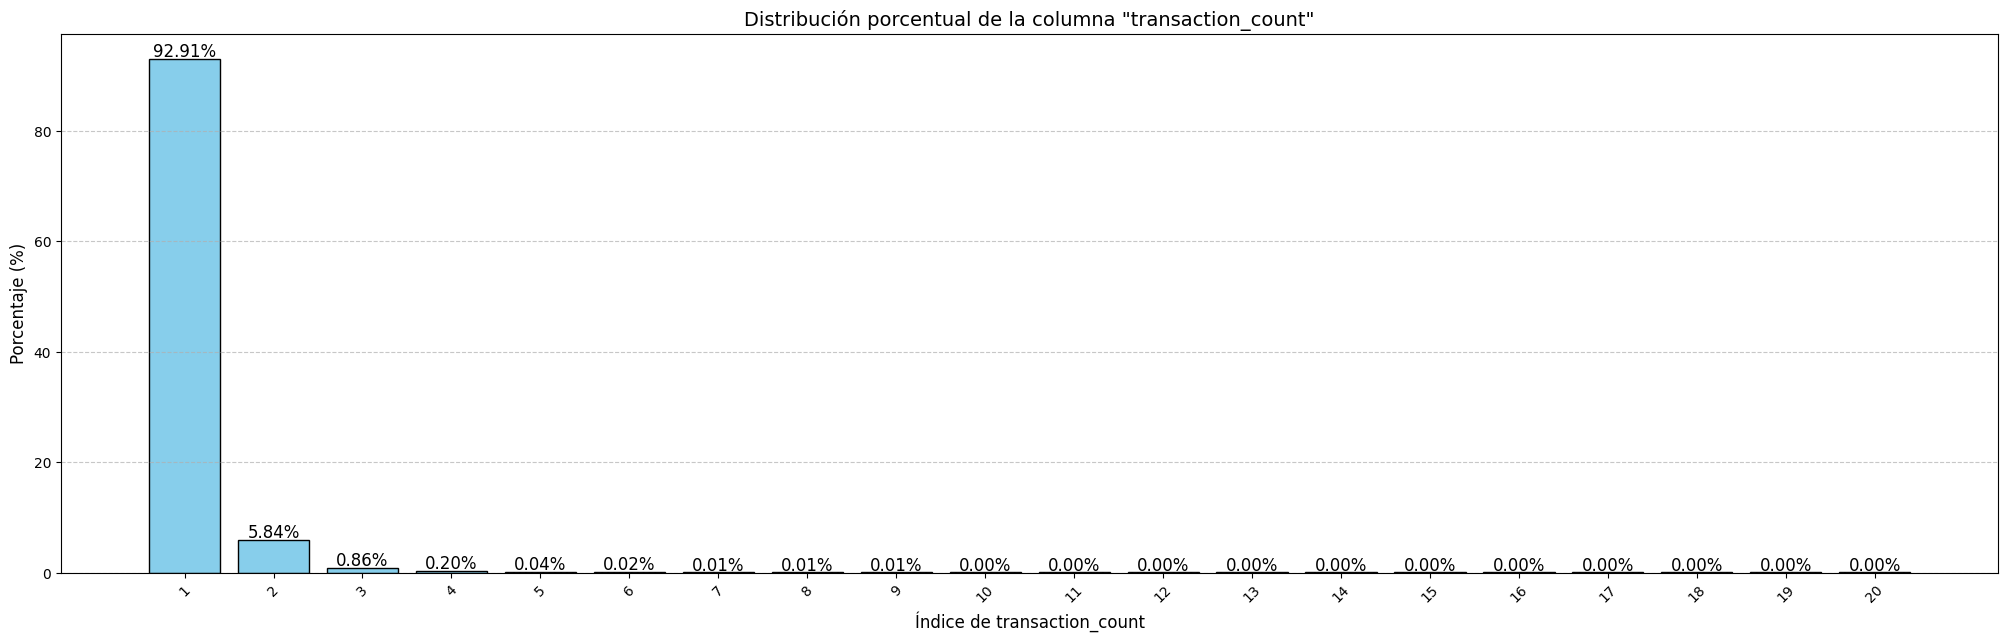

In [64]:
# Crear la figura y el eje con un tamaño más grande
fig, ax = plt.subplots(figsize=(25, 7))

# Graficar como barras usando el índice para las posiciones en el eje X
ax.bar(df_pandas.transaction_count, df_pandas["normalized_frequency"], color='skyblue', edgecolor='black')

# Agregar porcentaje encima de cada barra
for i, value in enumerate(df_pandas["normalized_frequency"]):
    ax.text(i+1, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

# Personalización de la gráfica
plt.xlabel('Índice de transaction_count', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.title('Distribución porcentual de la columna "transaction_count"', fontsize=14)
plt.xticks(ticks=range(df_pandas.transaction_count.min(), df_pandas.transaction_count.max() + 1), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

##### De aqui podemos decir que el indice de transaciones que son mayores a 3 por cliente es de menos del 1.25% 

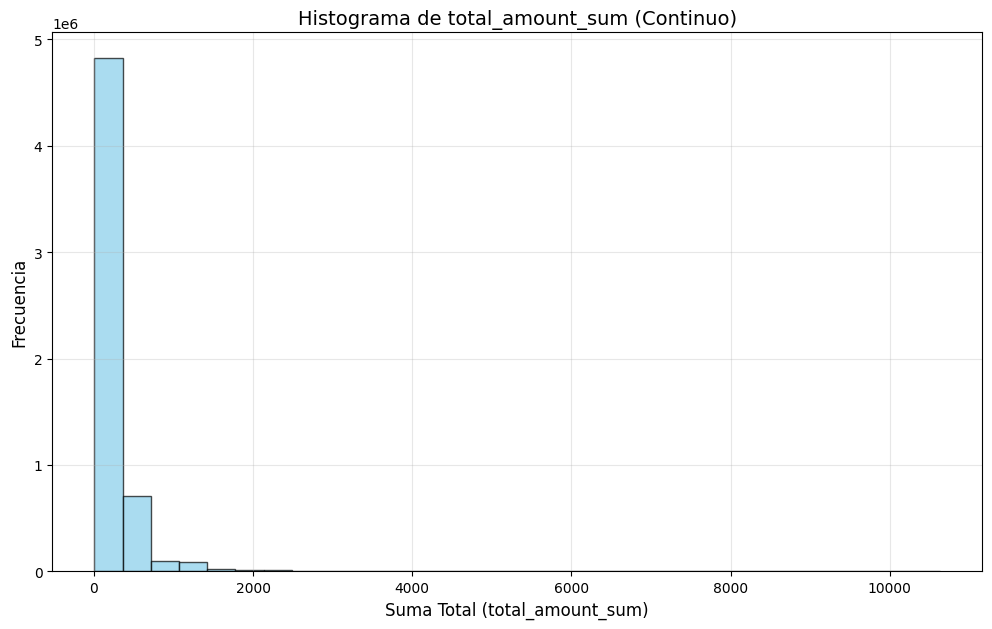

In [65]:
pandas_df = df_grouped.select("total_amount_sum").toPandas()
data = pandas_df["total_amount_sum"]

# Ahora graficar
plt.figure(figsize=(12, 7))
plt.hist(data, bins=30, density=False, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Suma Total (total_amount_sum)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Histograma de total_amount_sum (Continuo)', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

##### Vemos que la mayor cantidad de transacciones estan agrupadas en valores totales de menos de 2000 dolares por dia.

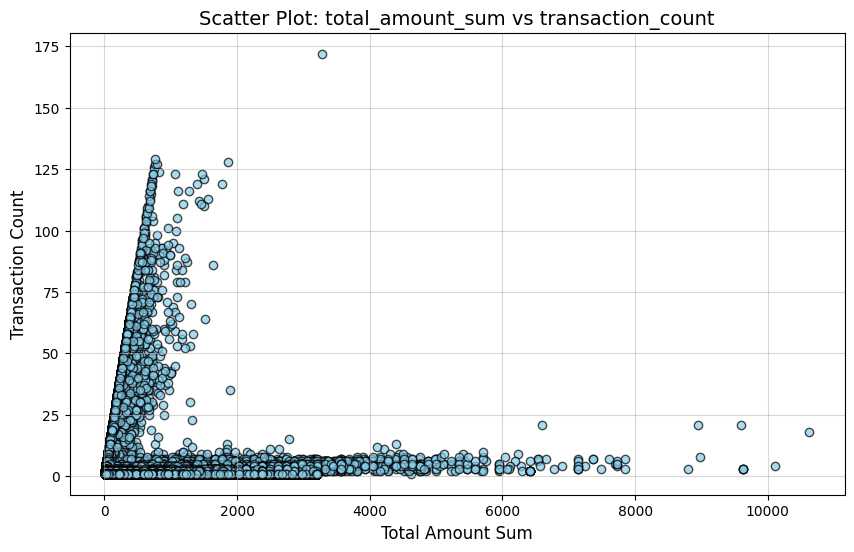

In [66]:
# Seleccionar solo las columnas necesarias y convertirlas a pandas
df_pandas = df_grouped.select('total_amount_sum', 'transaction_count').toPandas()

# Crear el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['total_amount_sum'], df_pandas['transaction_count'], alpha=0.7, color='skyblue', edgecolor='black')

# Personalización de la gráfica
plt.title('Scatter Plot: total_amount_sum vs transaction_count', fontsize=14)
plt.xlabel('Total Amount Sum', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.grid(alpha=0.5)

# Mostrar la gráfica
plt.show()

##### Esto nos da una idea, la cual es que las malas practicas transacioneale como el fracionamiento transacional, con cometidos por grades cantidades de valor, osea que entre mayor sea el valor a transferir mas probabilidad hay de que se haga  fracionamiento transacional.

### Generacion de Modelo

In [67]:
df_grouped.columns

['user_id', 'Fecha_dia', 'total_amount_sum', 'transaction_count']

In [126]:
# total_rows = df_grouped.count()
# half_rows = total_rows // 2  # División entera para obtener la mitad
# Seleccionar el 50% de las filas
# df_half = df_grouped.limit(half_rows)

fraction=0.05 # selecionamos el 25% de la data
df_half=df_grouped.sample(withReplacement=False,fraction=fraction)
# Convertir a pandas
df_half = df_half.toPandas()
df_half.shape

(288002, 4)

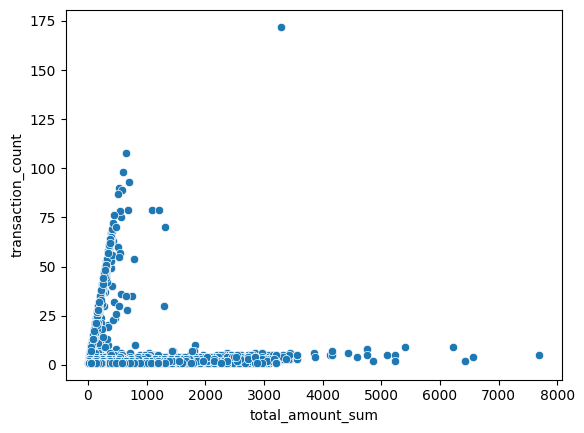

In [127]:
import seaborn as sns

sns.scatterplot(
    data=df_half, 
    x="total_amount_sum", 
    y="transaction_count"
)
plt.show()

### Utilizaremos el Algoritmo de DBSCAN para la deteccion de fraudes y deteccion de valores atipicos.

* esto bajo el criterio de que los datos no vienen etiquetados, por lo tanto, este deberá ser un modelo no supervisado. Y tratar de identificar esos clientes que posiblemente quieran realizar malas prácticas transaccionales

* La frecuencia en la cual se debería ejecutar el modelo para ir viendo que clientes sobrepasan las 3 transferencias debería ser hora a hora, dado que el análisis anterior me indica que para las transacciones totales menores a 3000 dólares, el tiempo promedio entre transacciones es de 44.32 minutos. y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a 5.79 minutos y para las transacciones totales mayores e iguales a 3000 dólares, el tiempo promedio entre transacciones es de 13.67 minutos. y que el 50% de estas transacciones se realizaron con una diferencia de tiempo entre ellas menor a 1.47 minutos., en este caso podemos usar mejor Azure Synapse, dado que es muy conveniente para analizar y manejar información en tiempo real de macrodatos dado que esta herramienta maneja lo mejor de SQL  y spark e integración de ETL.


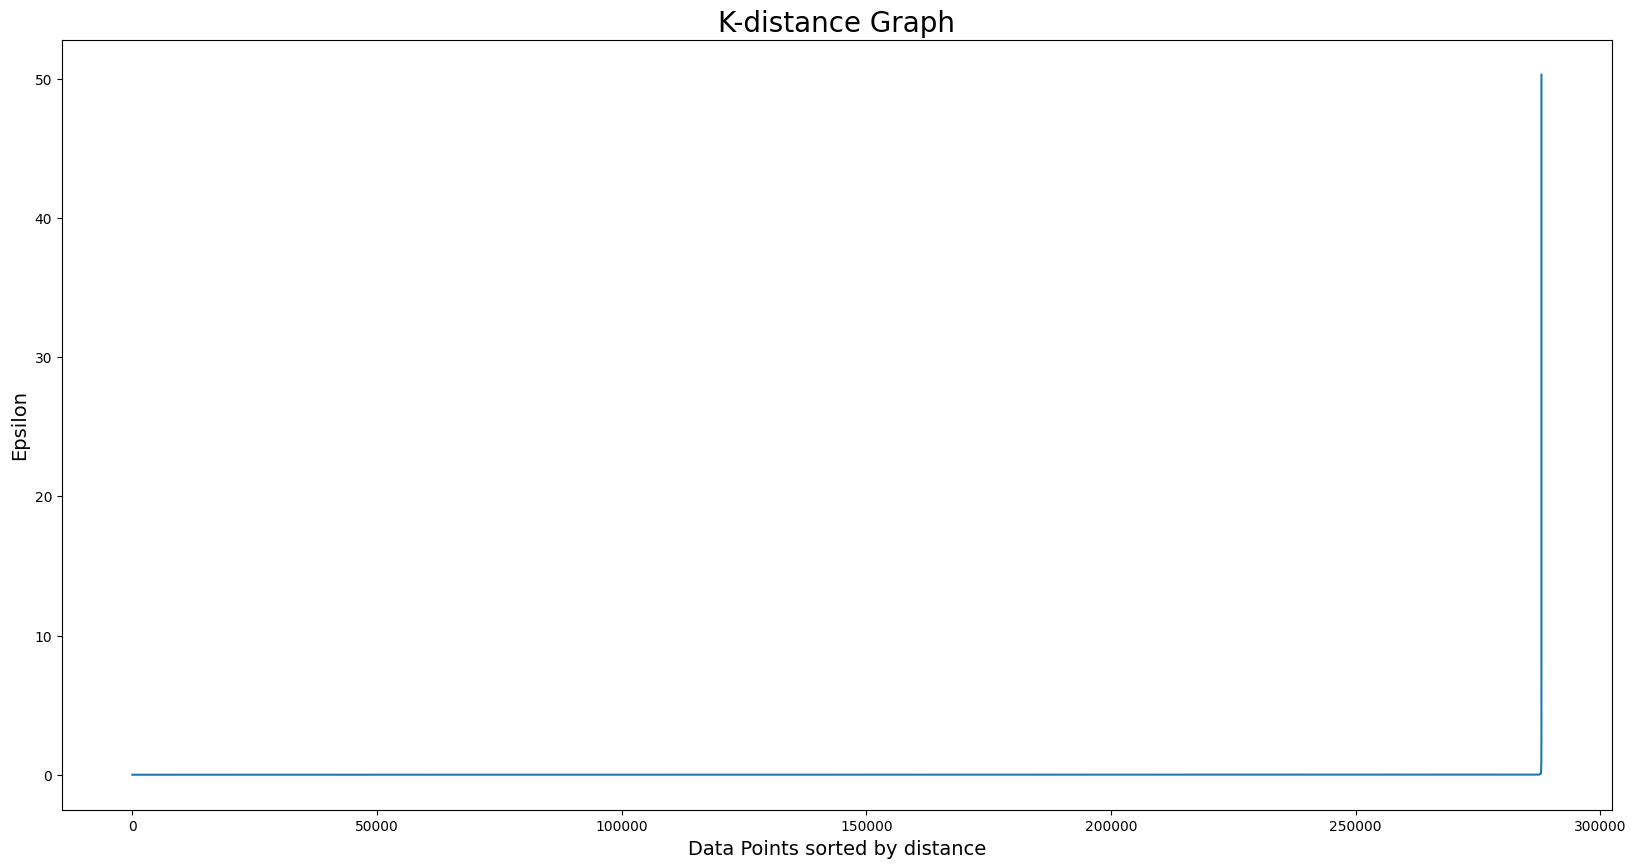

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_half[["total_amount_sum", "transaction_count"]])

# Recalcula el NearestNeighbors con los datos escalados
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Vuelves a graficar distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [129]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
# Definir el modelo KMeans
# n_clusters es el número de clústeres que deseas encontrar
model = KMeans(n_clusters=8, random_state=42).fit(X_scaled)

In [130]:
# Obtener etiquetas (a qué clúster pertenece cada punto)
labels = model.labels_

# Obtener los centros de los clústeres
centroids = model.cluster_centers_

In [131]:
print(f"Inercia del modelo: {model.inertia_}")

Inercia del modelo: 60215.41534906962


In [ ]:
labels

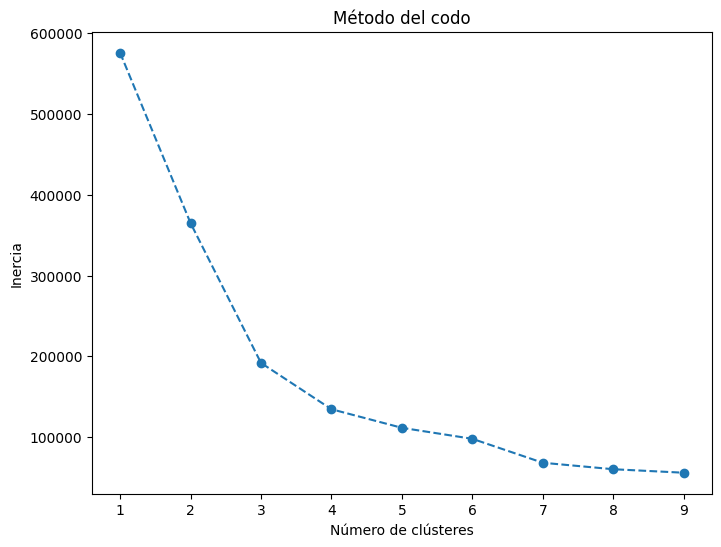

In [133]:
inertias = []
cluster_range = range(1, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o', linestyle='--')
plt.title("Método del codo")
plt.xlabel("Número de clústeres")
plt.ylabel("Inercia")
plt.show()
## vemos que el numero optimo de clouster es entre 5 y 8 ya que en estos puntos se estabiliza

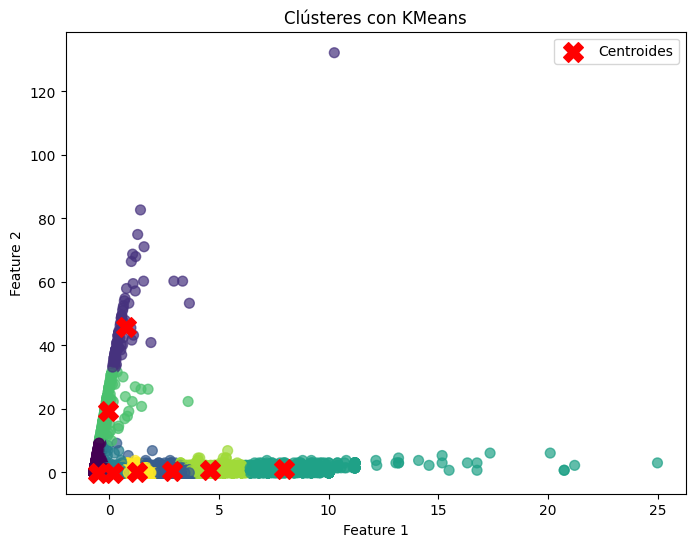

In [134]:
# Graficar los puntos y los clústeres
plt.figure(figsize=(8, 6))

# Dibujar los puntos del dataset con colores según los clústeres
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

# Dibujar los centros de los clústeres
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')

plt.title("Clústeres con KMeans")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

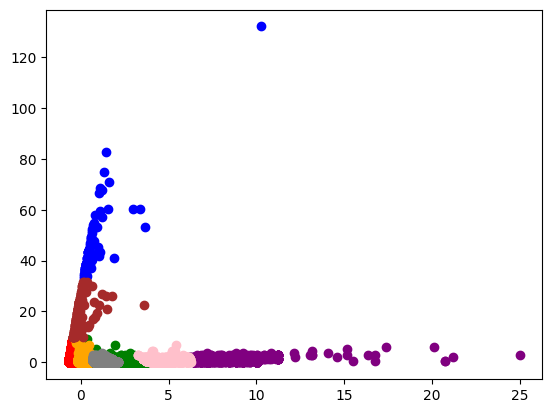

In [135]:
# Definir un listado de colores o un diccionario
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Asumimos que labels van de 0..7 para 8 clústeres
for cluster_id in range(8):
    # Filtrar los puntos que pertenecen al cluster_id
    cluster_points = (labels == cluster_id)
    plt.scatter(
        X_scaled[cluster_points, 0],
        X_scaled[cluster_points, 1],
        color=colors[cluster_id],
        label=f'Cluster {cluster_id}'
    )

#### DE aqui podemos decir que los cluster mas alejados son los mas propensos a encontra malas practicas transacionales

In [136]:
df_half['labels']=labels

In [137]:
df_half

,user_id,Fecha_dia,total_amount_sum,transaction_count,labels
0,0004158206fd6d4e946628df0f5b7ad4,2021-09-23,59.44455012,1,0
1,000485ca437832d26fb020e9fdcbc331,2021-05-19,297.22275061,1,3
2,0006601ccc6579ece6a8d4f3b616f58b,2021-09-21,1188.89100246,2,2
3,0006d504d524c03952dc4817ba65c43c,2021-02-02,58.25565911,3,0
4,0006d51e95ce979e4274840abf004f09,2021-02-26,297.22275061,1,3
...,...,...,...,...,...
287997,07c111a17f1baa435a6a4d83bf74ad27,2021-04-03,142.66692029,1,0
287998,4fcc4118c3766a4463d86d46237315eb,2021-04-01,23.77782004,1,0
287999,5cbc558d7b45e6348fd6f140712c4af6,2021-09-19,59.44455012,1,0
288000,4961f922eb458a22868ceee4fb20970f,2021-11-24,47.55564009,1,0


Se saca los datos de s3  luego se hace la automatizacion para ejecutar con airflow(ejecucion automatica , extraccion
 y limpieza.), que la extracion de los datos y modelo se debe hacer diaria
para identificar los datos atipicos. y volver a cargar los datos en un s3 de aws